In [1]:
include("sepsis_types.jl")
using .SepsisTypes
include("sepsis.jl")
using .Sepsis
include("inference.jl")
using .Inference
using Revise
using PyCall;
using Gen;
using CairoMakie
sepsis_gym = pyimport("custom_sepsis");

In [11]:
nr_episodes_history = 1

1

In [12]:
random_policies = [sepsis_gym.random_policy() for _ in 1:nr_episodes_history]
train_ep = [sepsis_gym.run_episode(policy) for policy in random_policies]
start_states = [to_state(ep.visited[1]) for ep in train_ep]

episodes = choicemap()
for (i, episode) in enumerate(train_ep)
    episodes = update_choicemap(episodes, i, episode)
end;

policies = [to_policy(pol) for pol in random_policies];



In [13]:
trace, sc = generate(sepsis_model, (policies, start_states));
sc

0.0

In [14]:
trace, sc, _, _ = update(trace, episodes)
sc

-Inf

In [15]:
traces = [trace]

1-element Vector{Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}}:
 Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Vector{Dict{State, Action}}, Vector{State}], false, Union{Nothing, Some{Any}}[nothing, nothing], Main.Sepsis.var"##sepsis_model#228", Bool[0, 0], false), Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}(:beliefs => Gen.ChoiceOrCallRecord{Gen.DynamicDSLTrace{DynamicDSLFunction{EnvParameters}}}(Gen.DynamicDSLTrace{DynamicDSLFunction{EnvParameters}}(DynamicDSLFunction{EnvParameters}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}[], Main.Sepsis.var"##get_beliefs#227", Bool[], false), Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}(:diab_vaso_on_bp_L_H => Gen.ChoiceOrCallRecord{Float64}(0.8955284223970931, -0.0, NaN, true), :nond_vaso_on_bp_L_N => Gen.ChoiceOrCallRecord{Float64}(0.8945209179779484, -0.0, NaN, true), :fluct => Gen.ChoiceOrC

In [16]:
nr_traces = 10000

while length(traces) < nr_traces
    for i in 1:nr_episodes_history
        (trace, acc) = mh(trace, select(:beliefs, :episode => i => :get_next => t for t in 1:10))
    end
    # trace = block_update(trace, nr_episodes_history)
    push!(traces, trace)
end

In [17]:
length(traces)


10000

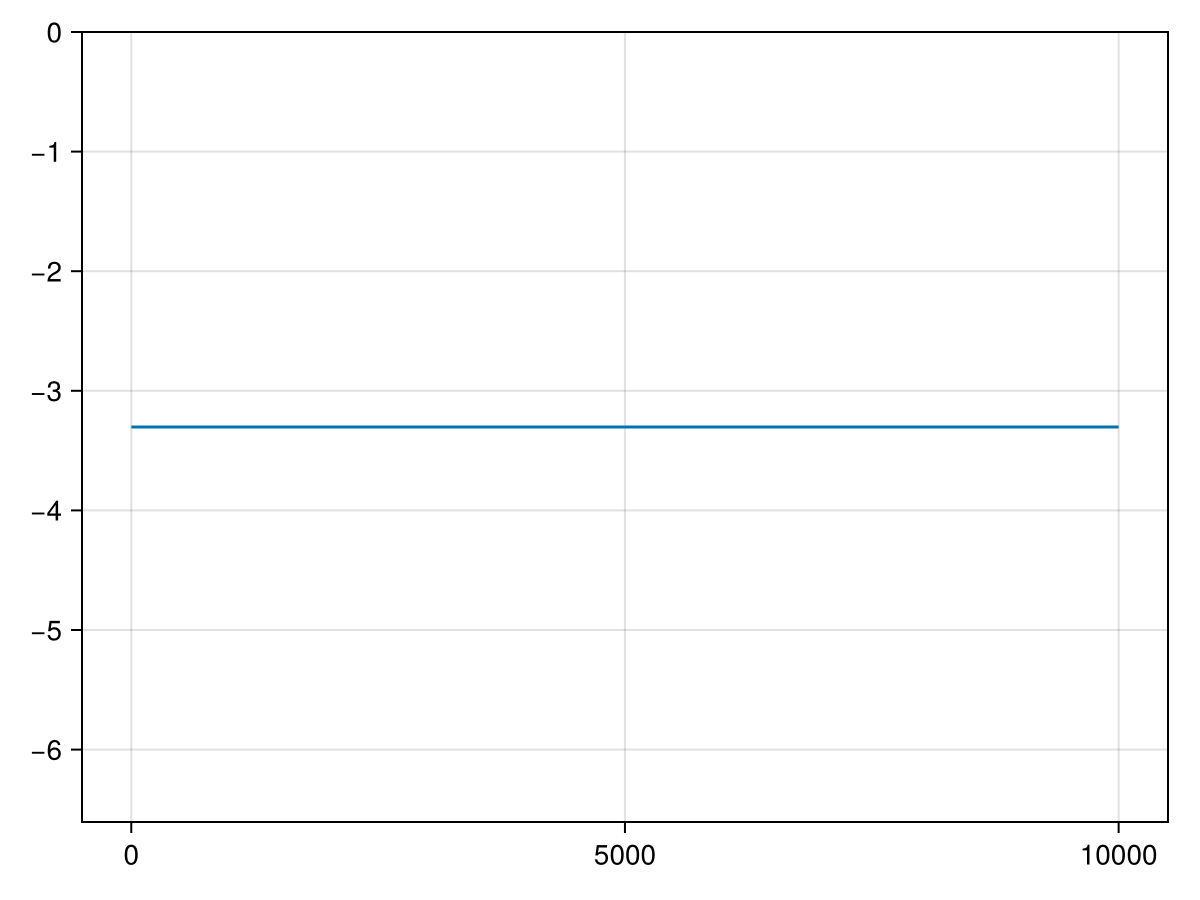

In [18]:
sums = [sum(sepsis_gym.TRUE_ENV_PARAMS .- get_env_params(trace[:beliefs])) for trace in traces]
lines(sums)